<a href="https://colab.research.google.com/github/RobMcH/gector/blob/master/Demo_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The cells below have to be executed once to setup everything - This might take a few minutes***

#### Notebook setup

Clone the Github repo:

In [1]:
!git clone https://github.com/RobMcH/gector

Cloning into 'gector'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 373 (delta 191), reused 196 (delta 110), pack-reused 80
Receiving objects: 100% (373/373), 1.67 MiB | 628.00 KiB/s, done.
Resolving deltas: 100% (222/222), done.


In [2]:
%cd /content/gector

/content/gector


Install requirements:

In [3]:
pip install -r requirements.txt

  Cloning https://github.com/amitness/nodebox_linguistics_extended (to revision master) to /tmp/pip-req-build-kv66dyo8
  Running command git clone -q https://github.com/amitness/nodebox_linguistics_extended /tmp/pip-req-build-kv66dyo8
     |████████████████████████████████| 773.1MB 24kB/s 
     |████████████████████████████████| 5.7MB 20.8MB/s 
Reason for being yanked: Insecure, upgrade to 0.12.1
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 389kB 37.6MB/s 
     |████████████████████████████████| 5.3MB 32.0MB/s 
     |████████████████████████████████| 1.1MB 25.0MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 3.6MB 26.8MB/s 
     |████████████████████████████████| 30.8MB 166kB/s 
     |████████████████████████████████| 122kB 39.5MB/s 
     |████████████████████████████████| 245kB 41.1MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 266kB 

In [4]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 11.1MB 13.0MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.1.0-cp37-none-any.whl size=11074434 sha256=580e727d2de5214fa06b8aa7a261fb2aa210cf7885f5d8d624436679ebd142ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-7c547isi/wheels/39/ea/3b/507f7df78be8631a7a3d7090962194cf55bc1158572c0be77f
Successfully built en-core-web-sm
  Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


Imports:

In [5]:
import os.path
from os import path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

import nltk
nltk.download('wordnet')

from IPython.display import SVG, Markdown
def printmd(string):
    display(Markdown(string))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
import sys

sys.path.insert(0, '/content/gector/utils')

from adversarial import convert_sentence

Load pre-trained model:

In [7]:
# Create new folder for pre-trained models and for the demo files
if path.exists('/content/gector/pre-trained-models') == False:
  os.mkdir('/content/gector/pre-trained-models')

# Create a folder where all temporary files for the demo will be saved
if path.exists('/content/gector/demo-files') == False:
  os.mkdir('/content/gector/demo-files')

# Load pre-trained Gector BERT model
if os.path.isfile('/content/gector/pre-trained-models/bert_0_gector.th') == False:
  !wget -P /content/gector/pre-trained-models https://grammarly-nlp-data-public.s3.amazonaws.com/gector/bert_0_gector.th

--2021-05-29 17:53:39--  https://grammarly-nlp-data-public.s3.amazonaws.com/gector/bert_0_gector.th
Resolving grammarly-nlp-data-public.s3.amazonaws.com (grammarly-nlp-data-public.s3.amazonaws.com)... 52.216.17.16
Connecting to grammarly-nlp-data-public.s3.amazonaws.com (grammarly-nlp-data-public.s3.amazonaws.com)|52.216.17.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448709742 (428M) [application/x-www-form-urlencoded]
Saving to: ‘/content/gector/pre-trained-models/bert_0_gector.th’

bert_0_gector.th    100%[===================>] 427.92M  29.3MB/s    in 14s     

2021-05-29 17:53:54 (30.4 MB/s) - ‘/content/gector/pre-trained-models/bert_0_gector.th’ saved [448709742/448709742]



Load baseline model:

In [8]:
from gector.gec_model import GecBERTModel

baseline_model = GecBERTModel(vocab_path='data/output_vocabulary',
                             model_paths=["pre-trained-models/bert_0_gector.th"],
                             max_len=50, min_len=3,
                             iterations=5,
                             min_error_probability=0.41,
                             lowercase_tokens=0,
                             model_name='bert',
                             special_tokens_fix=0,
                             log=False,
                             confidence=0.1,
                             is_ensemble=0,
                             weigths=None)

In [9]:
import spacy
from spacy.lang.en import English
from spacy.tokens import Doc, Token, Span
from spacy import displacy
from IPython.core.display import display, HTML
from matplotlib import cm

def visualise_changes(sentence, tags, label=None, color_options=None):
  '''
  Function to create a html which highlights the changes in a sentence

  INPUT:
  sentence        :   (str) sentence
  tags            :   (list) List with tupel (start, end) of each tag
  label           :   [optional] (list) Label for each index (e.g. "ORG")
  color_options   :   [optional] (dict) color setting for each label

  OUTPUT:
  html            :   (html) visualization of tags
  '''
  # Create nlp object (without a NER tagger in the pipeline)
  nlp = English()

  # Tokenize the sentence
  doc = nlp(sentence)

  # Check if custom labels should be used
  if label is None:
    # Default: Create a Span for each match and assign the label "PERTURBED"
    doc.ents = [Span(doc, start, end, label="PERTURBED") for start, end in tags]

    # Define coloring options
    #color_options = {"PERTURBED": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
    color_options = {"PERTURBED": "linear-gradient(90deg, rgba(170,156,252,0.5), rgba(252,156,231,0.5))"}
    options = {"ents": ["PERTURBED"], "colors": color_options}

  else:
    # Uppercase all labels
    label = [label_.upper() for label_ in label]

    # Otherwise use custom label
    doc.ents = [Span(doc, start, end, label=label) for (start, end), label in zip(tags, label)]

    # Get unique labels
    unique_labels = list(set(label))

    # Check if custom colors should be used
    if color_options is None:

      # Get the number of unique labels
      n_labels = len(unique_labels)
      
      # Create background colors as rgb
      rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

      color_options = {}

      # Add colors
      for i, label in enumerate(unique_labels):
        #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
        hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
        hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
        color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"
    
    # Create the color options
    options = {"ents": unique_labels, "colors": color_options}

  # Create html and print output
  html = displacy.render(doc, style="ent", options=options)

  # return modified doc
  return html

In [10]:
with open('/content/gector/data/output_vocabulary/labels.txt') as f:
    gector_label = f.readlines()
    
# remove whitespace characters like `\n` at the end of each line
gector_label = [x.strip() for x in gector_label] 

# **Adversarial Training for Grammatical Error Correction**

*David Byrne, Alan Jeffares, Robert McHardy, Nils Zerrer*

This notebook provides a functional overview of the optimised Gector model as presented in our paper. The notebook consists of two parts:
* The first part is a **personalised demo** where the different parts of the model can be tested using arbitrary examples
* In the second part, specific improvements on pre-defined sentences are **showcased**

## **Personalised demo**

The section below contains a personalised demo. Please feel free to use different sentences and test the model.

Please enter your example sentence below and **[run the cell]**:

In [39]:
sentence = "The girl and the boy going eats dinner" #@param {type:"string"} 

perturbations, weights, tokens, indices = convert_sentence(sentence, '', baseline_model, 5)

### Attention weight

As a first step, we extract the weights from the first attention head which is depicted below for an arbitrary example sentence:

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/attention_weights.svg">
</p>

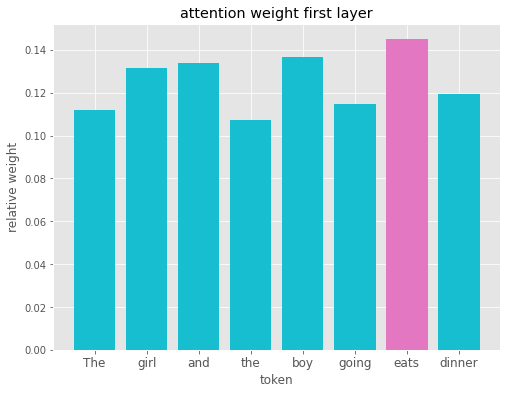

In [40]:
#@markdown **[run the cell]** For your given example sentence, the attention weight in the first attention head is distributed as follows:

weight = weights[0]

x_pos = [i for i, _ in enumerate(tokens)]

max_weight = weight.max()

colors = []
for val in weight:
    if val == max_weight:
        colors.append('tab:pink')
    else:
        colors.append('tab:cyan')

#(0.0, 0.6875, 0.9375)

plt.rcParams['xtick.labelsize']=12

bar_width = max(1, len(max(tokens, key=len))*0.15)

f, ax = plt.subplots(figsize=(bar_width*weight.size,6)) # set the size that you'd like (width, height)
plt.bar(x_pos, weight, color=colors)
plt.xlabel("token")
plt.ylabel("relative weight")
plt.title("attention weight first layer")

plt.xticks(x_pos, tokens)


plt.show()

### Perturbation

We use the attention weight information to identify which token is most relevant in making a decision about the correctness of a sentence. The token with the highest overall weight is then perturbed using a rule-based approach. This assures that we not only generate gramatically wrong sentences, but also sentences on which the model is likely to fail:

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/adversarial_sample_generation.svg" width="600"/>
</p>

In [41]:
#@markdown **[run the cell]** Perturbed sentences:

printmd('**Original sentence:**')
html = visualise_changes(sentence, [(0,0)])
display(HTML(html))
print('\n')

for i, perturbation in enumerate(perturbations):
  if indices[i] == -1:
    html = visualise_changes(perturbation[0][0], [(0,0)])
    printmd('**Perturbed sentence ' + str(i+1) + ' (removed token):**')
  else:
    html = visualise_changes(perturbation[0][0], [(indices[i],indices[i]+1)])
    printmd('**Perturbed sentence ' + str(i+1) + ':**')
  display(HTML(html))

  if i < 4:
    print('\n')

**Original sentence:**

**Perturbed sentence 1:**

**Perturbed sentence 2:**

**Perturbed sentence 3 (removed token):**

**Perturbed sentence 4:**

**Perturbed sentence 5 (removed token):**

### Tagging and Correction

<p align="center">
<img src="https://raw.githubusercontent.com/RobMcH/gector/master/figures/gector_pipeline.svg" width="600"/>
</p>



In [42]:
#@markdown **[run the cell]** The model (choose either ours or the basline) makes the following iterative corrections:
model = "Baseline" #@param ["Ours", "Baseline"]

if model == 'Ours':
  pred_model = baseline_model
else:
  pred_model = baseline_model

printmd('**Original sentence:**')
html = visualise_changes(sentence, [(0,0)])
display(HTML(html))
print('\n')

# Create nlp object
nlp = English()

# Tokenize the sentence
tokens = [token.text for token in nlp(sentence)]

# Make prediction
pred_result = pred_model.handle_batch([tokens], True)

# Get number of iterations until correct sentence / max iterations reached
n_iterations = len(pred_result[2])

# Counter for number of changes
n_changes = 0

# Array of input sentences after each iteration
input_sentences = []

# Create colors
all_labels = []
for i in range(n_iterations):
  all_labels += pred_result[2][i][2][0]

unique_labels = list(set([gector_label[label].upper() for label in all_labels]))

n_labels = len(unique_labels)

# Create background colors as rgb
rgb_vals = (cm.get_cmap('hsv')(np.linspace(0.05,0.6,2*n_labels))*255).astype(int)

color_options = {}

# Add colors
for i, label in enumerate(unique_labels):
  #color_options[label] = "rgba(" + str(rgb_vals[i,0]) + ", " + str(rgb_vals[i,1]) + ", " + str(rgb_vals[i,2]) + ", " + str(0.7) + ")"
  hex1 = '#%02x%02x%02x' % (rgb_vals[2*i,0], rgb_vals[2*i,1], rgb_vals[2*i,2])
  hex2 = '#%02x%02x%02x' % (rgb_vals[2*i+1,0], rgb_vals[2*i+1,1], rgb_vals[2*i+1,2])
  color_options[label] = "linear-gradient(90deg, " + hex1 + ", " + hex2 + ")"

# For each iteration
for i in range(n_iterations):
  input_tokens = pred_result[2][i][0][0]
  
  predicted_tags = pred_result[2][i][2][0][1:]

  input_sentence = ''
  n_tokens = len(input_tokens)

  for j, token in enumerate(input_tokens):
    if j < (n_tokens-1):
      input_sentence += token + ' '
    else:
      input_sentence += token
  
  tag_indexes = []
  label = []

  for k, predicted_tag in enumerate(predicted_tags):
    if not predicted_tag == 0:
      tag_indexes.append((k, k+1))
      label.append(gector_label[predicted_tag])

  if tag_indexes:
    printmd('**Iteration ' + str(i+1) + ':**')
    html = visualise_changes(input_sentence, tag_indexes, label, color_options)
    display(HTML(html))
    print('\n')
  else:
    printmd('**Model output:**')
    html = visualise_changes(input_sentence, [(0,0)])
    display(HTML(html))

**Original sentence:**

**Iteration 1:**

**Iteration 2:**

**Model output:**

## **Showcase**

In the following we present the specific improvements for pre-defined sentences.